In [1]:
%matplotlib inline

In [2]:
pwd

'/home/andre/Projects/stocks/prototypes'

In [3]:
cd ..

/home/andre/Projects/stocks


In [4]:
from matplotlib import pyplot as plt
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos.util import progressbar
from algos import meta5Ibov
import scipy
import random
from numba import njit, prange

In [5]:
import os

if os.name == 'nt':
    meta5Ibov.setDataPath(r'C:\Users\alferreira\Documents\stocks\data', 
                        r'C:\Users\alferreira\Documents\stocks\data')
else:
    meta5Ibov.setDataPath(r'/home/andre/Projects/stocks/data', 
                        r'/home/andre/Projects/stocks/data')

Master data loaded size (minutes):  512773
symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']


In [6]:
pwd

'/home/andre/Projects/stocks'

In [7]:
meta5Ibov.loadMeta5Data(cleandays=False, preload=False)

symbols loaded:
['BBAS3' 'DOL$' 'VALE3' 'ABEV3' 'ITUB4' 'B3SA3' 'BBDC4' 'PETR4' 'WIN@']
percent missing:  0.018196093876296074


9

In [8]:
prices = meta5Ibov.getSymbol('WIN@')

In [9]:
len(prices)

512773

In [10]:
prices.tail(1)

,O,H,L,C,TV,S,RV
time,,,,,,,
2019-07-11 16:54:00,105605.0,105620.0,105585.0,105600.0,1885,1,8501


Por exemplo, imagine o seguinte histórico de negociações:  
Ativo	Preço	Quantidade  
PETR4	14,00	1.000  
PETR4	14,05	1.500  
PETR4	13,95	300  
No quadro acima nós temos um total de 3 negócios realizados (logo, volume de ticks = 3), totalizando 2.800 ações negociagadas (logo, volume real = 2.800).

In [11]:
# apply log just after the groupby agg sum otherwise cannot make sense of RV
# prices.RV = np.log(prices.RV+1)  # to log scale

Last 21 business days

In [12]:
len(prices)

512773

In [13]:
prices = prices[-5*9*60:]

In [14]:
prices.tail(2)

,O,H,L,C,TV,S,RV
time,,,,,,,
2019-07-11 16:53:00,105615.0,105625.0,105600.0,105605.0,1004,1,3838
2019-07-11 16:54:00,105605.0,105620.0,105585.0,105600.0,1885,1,8501


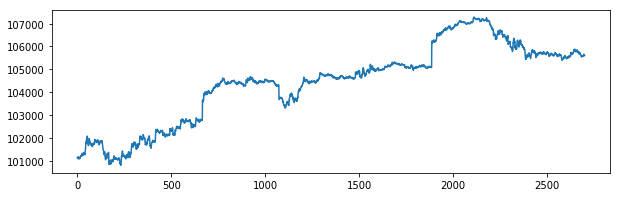

In [15]:
plt.figure(figsize=(10,3))
plt.plot(prices.C.values)

In [16]:
cprices = prices.C.values

In [17]:
from sklearn.mixture import GaussianMixture as gmm
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.cluster import KMeans, MeanShift
from sklearn.neighbors import KernelDensity as kd

In [18]:
from scipy.signal import argrelextrema

In [19]:
ticksize = 5
amin = int(np.floor(np.min(cprices))/ticksize)*ticksize
amax = int(np.ceil(np.max(cprices))/ticksize)*ticksize

In [20]:
bins = np.arange(amin-5, amax+5, 5)

In [21]:
bins

array([100790, 100795, 100800, ..., 107275, 107280, 107285])

In [22]:
prices['bins'] = np.searchsorted(bins, prices.C)

In [23]:
prices.tail()

,O,H,L,C,TV,S,RV,bins
time,,,,,,,,
2019-07-11 16:50:00,105640.0,105670.0,105630.0,105660.0,1628,1,6010,974
2019-07-11 16:51:00,105655.0,105670.0,105640.0,105640.0,1273,1,5146,970
2019-07-11 16:52:00,105640.0,105650.0,105600.0,105610.0,2242,1,9047,964
2019-07-11 16:53:00,105615.0,105625.0,105600.0,105605.0,1004,1,3838,963
2019-07-11 16:54:00,105605.0,105620.0,105585.0,105600.0,1885,1,8501,962


In [24]:
len(bins)

1300

In [25]:
pricescount = prices.groupby('bins').C.agg('count')
rvsum = prices.groupby('bins').RV.sum()
tvsum = prices.groupby('bins').TV.sum()

In [26]:
hists = pd.DataFrame(index=np.arange(0, len(bins)), columns=['pcount', 'rvsum', 'tvsum'])
hists.loc[pricescount.index, 'pcount'] = pricescount
hists.loc[rvsum.index, 'rvsum'] = rvsum
hists.loc[tvsum.index, 'tvsum'] = tvsum

In [27]:
hists.fillna(0, inplace=True)

### Histogram of Prices

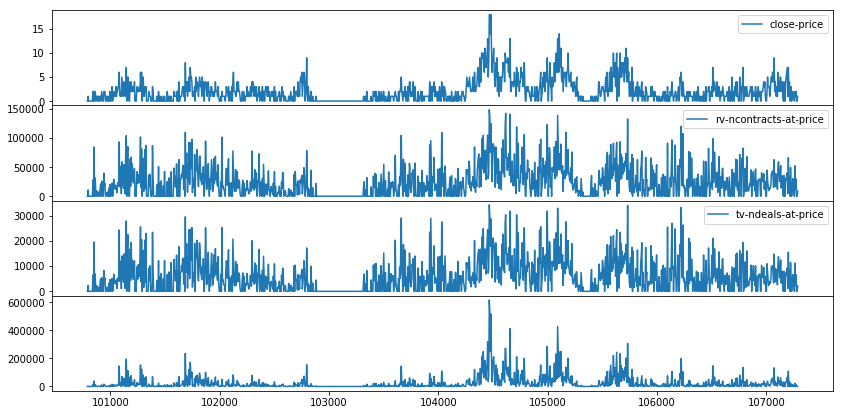

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(14,7))
ax1.plot(bins, hists.pcount, label='close-price')
ax1.get_xaxis().set_ticks([])
ax2.plot(bins, hists.rvsum, label='rv-ncontracts-at-price')
ax2.get_xaxis().set_ticks([])
ax3.plot(bins, hists.tvsum, label='tv-ndeals-at-price')
ax3.get_xaxis().set_ticks([])
ax4.plot(bins, hists.tvsum*hists.pcount, label='tv-ndeals-at-price*histprices')
ax1.legend()
ax2.legend()
ax3.legend()
plt.subplots_adjust(hspace=0)

In [29]:
hists.corr()

,pcount,rvsum,tvsum
pcount,1.000000,0.822028,0.794336
rvsum,0.822028,1.000000,0.993433
tvsum,0.794336,0.993433,1.000000


### Discussion of this information

- We know that mini-bovespa is the derivative with more individual investors on b3 stock-exchange

- The volume at price seams very spreaded and doesn't seam to change much 
    - The correlaton of 84% migh be due to institutional investors using arima or another technique. of regression over the bovespa components to profit along the trajectory by selling/buying. So where the prices stay a longer time will end up having more negotiation and counts. 
    - Still I find the correlation low maybe because it's an derivative of ibovespa index
    - Is it possible to correct create histogram of time spent at each price? The histogram of counts at price already is that since every data point corresponts to one minute.    
    - If we multiply the histogram of prices by the histogram of volume at price we may have a interesting product. Where at each price we have how much or how long it was alive besides the volume invested in there. 
    
    
### Despite of all that seams that the histogram of counts is the best option here

- It's simpler to start with
- Since it's an index being tracked

In [30]:
input_hist = hists.rvsum*hists.pcount

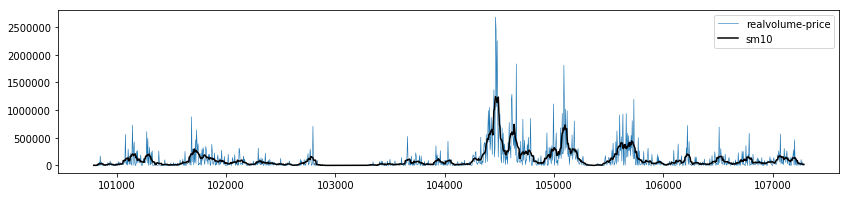

In [31]:
plt.figure(figsize=(14,3))
plt.plot(bins, input_hist, label='realvolume-price', lw=0.6)
sma_rvprices = np.convolve(input_hist, np.ones(10)*1./10, mode='same')
plt.plot(bins, sma_rvprices, 'k',  label='sm10')
plt.legend()

- kernel density has the advantage to be able to calculate probabilities or cdf for any price 

How to discriminate peaks

- Define a threshold
- Use order to avoid peaks too close apart
- how to deal with borders? for while ignore it

Better specify a fixed threshold ? Less than 500 contracts negotiated is meaningless?

In [34]:
threshold = np.percentile(sma_rvprices, [60])[0]  
threshold

71979.86

- Based on argextrema use lateral comparison defined by order ( number of point on each side)
- Also use threshold to ignore points bellow certain value

In [88]:
order = 15 # 15*5 = 75 points distance minimum between peaks
# for i in range(order+1):
# not threating the borders 0 to order - len-order

peaks = []
    
for i in range(order, len(sma_rvprices)-order):
    if sma_rvprices[i] < threshold:
        continue
    flag = True        
    for j in range(1, order+1):
        if sma_rvprices[i] <= sma_rvprices[i-j] or sma_rvprices[i] <= sma_rvprices[i+j]:
            flag = False
            break # not a maximum
    if flag:
        peaks.append(i)

In [89]:
peaks

[76,
 101,
 184,
 271,
 305,
 397,
 577,
 631,
 735,
 769,
 796,
 862,
 984,
 1066,
 1085,
 1147,
 1195,
 1255,
 1282]

In [90]:
peaks = np.sort(peaks)

In [91]:
xpeaks = bins[peaks]

In [92]:
xpeaks

array([101170, 101295, 101710, 102145, 102315, 102775, 103675, 103945,
       104465, 104635, 104770, 105100, 105710, 106120, 106215, 106525,
       106765, 107065, 107200])

#### Water-gradient style

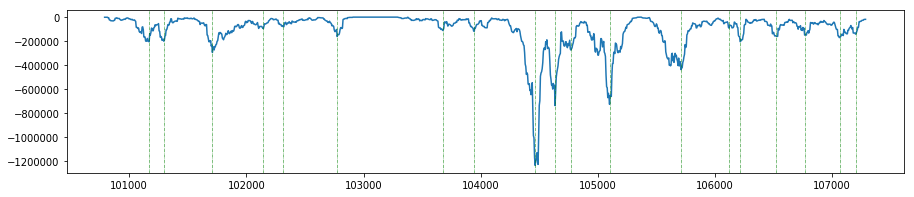

In [93]:
plt.figure(figsize=(15,3))
plt.plot(bins, -sma_rvprices)
for xc in xpeaks.flatten():
    plt.axvline(x=xc, color='g', ls='-.', lw=0.5)

In [94]:
xpeaks

array([101170, 101295, 101710, 102145, 102315, 102775, 103675, 103945,
       104465, 104635, 104770, 105100, 105710, 106120, 106215, 106525,
       106765, 107065, 107200])

In [95]:
sma_rvprices[peaks]

array([ 206120.9,  201127.5,  295157.2,   95913.2,   80653.9,  162499.2,
        111447.5,  117911.5, 1239842.7,  739933.1,  275016. ,  729596.8,
        438695.6,   91875.6,  205358.3,  161743.4,  150302.5,  170723.1,
        142565.9])